# Cifar10 - exercicio de classificar 3 classes

Fazer classificação de 3 classes usando rede neural convolucional.
Não utilizar o pacote sklearn. Apenas o Keras e o NumPy.

Não utilizar a função de acompanhamento de gráficos durante o treinamento.

Gerar uma figura mosaic que contenha as 5 imagens de classificação correta de menor probabilidade de predição.

Gerar esta figura com o nome: cifar_fig.png

## Importação de bibliotecas

In [1]:
import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop, SGD
import keras.regularizers as reg
from keras.utils import np_utils

import keras.backend as K
K.set_image_data_format('channels_first')
K.set_floatx('float32')

Using TensorFlow backend.


## Carregamento do dataset

In [2]:
data = np.load('cifar10-redux.npz')

In [3]:
X = data['X_train']
y = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [4]:
X.shape, y.shape, X_test.shape, y_test.shape

((2000, 3, 32, 32), (2000,), (500, 3, 32, 32), (500,))

In [5]:
X.dtype, y.dtype, X_test.dtype, y_test.dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('int64'))

## Normalização dos dados

In [6]:
X = X.astype('float32')
X_test = X_test.astype('float32')
X /= 255.
X_test /= 255.

# transforma labels em 0, 1 e 2, ao invés de 3, 4 e 5
y = y - 3
y_test = y_test - 3

## Separação dos dados de treinamento em treinamento e validação

In [7]:
# numero de passageiros
nb_data = X.shape[0]

# semente fixa para dar reproducibilidade
seed = 13
np.random.seed(seed)

msk = np.random.rand(nb_data) < 0.80
X_train = X[msk]
X_validate = X[~msk]
y_train = y[msk]
y_validate = y[~msk]

print(X_train.shape)
print(X_validate.shape)
print(y_train.shape)
print(y_validate.shape)

(1605, 3, 32, 32)
(395, 3, 32, 32)
(1605,)
(395,)


## Transforma o vetor de labels para o formato de one-hot encoding.

In [8]:
nb_classes = 3

y_oh = np_utils.to_categorical(y, nb_classes)
y_train_oh = np_utils.to_categorical(y_train, nb_classes)
y_validate_oh = np_utils.to_categorical(y_validate, nb_classes)
y_test_oh = np_utils.to_categorical(y_test, nb_classes)

## Construíndo a CNN com o Keras

In [55]:
img_rows, img_cols = 32, 32 # Dimensões das imagens
input_shape = (3, img_rows, img_cols)

# Definindo a rede
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(48,(3,3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Aqui os features deixam de ser imagens
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.75))
model.add(Dense(nb_classes, kernel_regularizer=reg.l2(0.025)))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 32, 30, 30)        896       
_________________________________________________________________
activation_59 (Activation)   (None, 32, 30, 30)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 64, 28, 28)        18496     
_________________________________________________________________
activation_60 (Activation)   (None, 64, 28, 28)        0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 48, 12, 12)        27696     
__________

## Compilando a rede

In [56]:
loss = 'categorical_crossentropy'
opt = RMSprop()

model.compile(loss=loss, optimizer=opt, metrics=["accuracy"]) 

## Callbacks

In [57]:
checkpointer = ModelCheckpoint(filepath='cifar10.hdf5', monitor='val_acc', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

## Treinamento da rede

In [58]:
batch_size = 10
tr_epochs = 50

history = model.fit(
        X_train, 
        y_train_oh, 
        batch_size=batch_size, 
        epochs=tr_epochs,
        validation_data=(X_validate, y_validate_oh),
        callbacks=[earlystopper, checkpointer]
         )

Train on 1605 samples, validate on 395 samples
Epoch 1/50
1605/1605 [==============================] - 2s - loss: 1.1869 - acc: 0.3396 - val_loss: 1.1131 - val_acc: 0.4759
Epoch 2/50
1605/1605 [==============================] - 1s - loss: 1.0681 - acc: 0.4505 - val_loss: 1.0096 - val_acc: 0.5443
Epoch 3/50
1605/1605 [==============================] - 1s - loss: 0.9860 - acc: 0.5283 - val_loss: 1.0090 - val_acc: 0.5468
Epoch 4/50
1605/1605 [==============================] - 1s - loss: 0.9583 - acc: 0.5458 - val_loss: 1.0247 - val_acc: 0.5241
Epoch 5/50
1605/1605 [==============================] - 1s - loss: 0.9255 - acc: 0.5614 - val_loss: 0.9356 - val_acc: 0.5646
Epoch 6/50
1605/1605 [==============================] - 1s - loss: 0.9055 - acc: 0.5713 - val_loss: 0.9397 - val_acc: 0.5873
Epoch 7/50
1605/1605 [==============================] - 1s - loss: 0.8926 - acc: 0.5819 - val_loss: 0.9435 - val_acc: 0.6025
Epoch 8/50
1605/1605 [==============================] - 0s - loss: 0.8821 - ac

## Apaga modelo atual

In [59]:
del model

## Carrega modelo salvo em disco

In [60]:
model = load_model('cifar10.hdf5')

## Avaliação do treinamento no conjunto de testes com o melhor modelo

In [61]:
loss, accuracy = model.evaluate(X_test, y_test_oh, batch_size=10)
print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

230/500 [============>.................] - ETA: 0s 
[INFO] accuracy on the test data set: 65.40% [0.99932]


## Novo treinamento da rede com os dados de validação até a época 39

In [62]:
batch_size = 10
tr_epochs = 39

history = model.fit(
        X, 
        y_oh, 
        batch_size=batch_size, 
        epochs=tr_epochs,
         )

Epoch 1/39
2000/2000 [==============================] - 1s - loss: 0.6616 - acc: 0.7580     
Epoch 2/39
2000/2000 [==============================] - 1s - loss: 0.6321 - acc: 0.7645     
Epoch 3/39
2000/2000 [==============================] - 1s - loss: 0.6181 - acc: 0.7765     
Epoch 4/39
2000/2000 [==============================] - 1s - loss: 0.6171 - acc: 0.7730     
Epoch 5/39
2000/2000 [==============================] - 1s - loss: 0.5925 - acc: 0.7800     
Epoch 6/39
2000/2000 [==============================] - 1s - loss: 0.5964 - acc: 0.7805     
Epoch 7/39
2000/2000 [==============================] - 1s - loss: 0.5724 - acc: 0.7810     
Epoch 8/39
2000/2000 [==============================] - 1s - loss: 0.5852 - acc: 0.7930     
Epoch 9/39
2000/2000 [==============================] - 1s - loss: 0.5479 - acc: 0.7995     
Epoch 10/39
2000/2000 [==============================] - 1s - loss: 0.5747 - acc: 0.7980     
Epoch 11/39
2000/2000 [==============================] - 1s - loss: 0

## Salva modelo treinado em disco

In [63]:
model.save('cifar10-best.hdf5')

## Avaliação do treinamento no conjunto de testes com o novo modelo

In [65]:
loss, accuracy = model.evaluate(X_test, y_test_oh, batch_size=10)
print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

330/500 [==================>...........] - ETA: 0s
[INFO] accuracy on the test data set: 64.40% [0.87991]


## Exercício opcional - Nota de bonus - adicional na nota

## Cria a figura do tamanho adequado para a correção automática

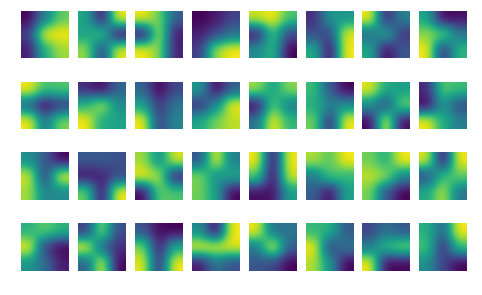

In [5]:
model = load_model('cifar10-best.hdf5')

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,5))

plt.title('Visualizacão dos kernels da primeira camada convolucional')
weights = model.layers[0].get_weights()[0][0,:,:,:]
for i in range(0,weights.shape[2]):
    plt.subplot(4,8,i+1)
    plt.imshow(weights[:,:,i], interpolation='gaussian')
    plt.axis('off')

plt.show()
fig.savefig('my_kernels.png')